In [ ]:
!pip install tensorflow xgboost scikit-learn pandas numpy


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# XGBoost
from xgboost import XGBClassifier

In [ ]:
# Load dataset (replace with your fraud dataset)
data = pd.read_csv('balanced_dataset.csv')

# One-hot encode categorical columns
data = pd.get_dummies(data, columns=['type', 'nameOrig', 'nameDest'])

# Split features & target
X = data.drop('isFraud', axis=1)
y = data['isFraud']

# Label encode remaining categorical features
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for CNN (samples, timesteps, channels)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Define CNN model
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, verbose=1)

# Extract CNN features (remove the last layer)
feature_extractor = Model(inputs=cnn_model.inputs, outputs=cnn_model.layers[-2].output)
cnn_features_train = feature_extractor.predict(X_train_cnn)
cnn_features_test = feature_extractor.predict(X_test_cnn)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5646 - loss: 0.6832
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9759 - loss: 0.2856
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9981 - loss: 0.1107
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0415
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0182
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0078
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0043
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0016
1/7 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 515, 1))
  warnings.warn(msg)


4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 515, 1))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step 


In [ ]:
# Train XGBoost on CNN-extracted features
xgb_model = XGBClassifier()
xgb_model.fit(cnn_features_train, y_train)

# Evaluate
xgb_predictions = xgb_model.predict(cnn_features_test)
print("XGBoost on CNN Features - Accuracy:", accuracy_score(y_test, xgb_predictions))
print(classification_report(y_test, xgb_predictions))

XGBoost on CNN Features - Accuracy: 0.7254901960784313
              precision    recall  f1-score   support

         0.0       0.65      0.92      0.76        24
         1.0       0.88      0.56      0.68        27

    accuracy                           0.73        51
   macro avg       0.76      0.74      0.72        51
weighted avg       0.77      0.73      0.72        51



In [ ]:
# Get CNN probabilities
cnn_probs = cnn_model.predict(X_test_cnn).flatten()

# Train XGBoost on original features (not CNN-extracted)
xgb_model_raw = XGBClassifier()
xgb_model_raw.fit(X_train, y_train)
xgb_predictions_raw = xgb_model_raw.predict(X_test)

# Stack predictions
stacked_features = np.column_stack((cnn_probs, xgb_predictions_raw))

# Meta-model (Logistic Regression)
from sklearn.linear_model import LogisticRegression
meta_model = LogisticRegression()
meta_model.fit(stacked_features, y_test)

# Final predictions
stacked_predictions = meta_model.predict(stacked_features)
print("\nStacked CNN+XGBoost - Accuracy:", accuracy_score(y_test, stacked_predictions))
print(classification_report(y_test, stacked_predictions))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

Stacked CNN+XGBoost - Accuracy: 0.9607843137254902
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        24
         1.0       0.93      1.00      0.96        27

    accuracy                           0.96        51
   macro avg       0.97      0.96      0.96        51
weighted avg       0.96      0.96      0.96        51



In [ ]:
print("=== Model Comparison ===")
print(f"1. CNN Alone: {accuracy_score(y_test, (cnn_model.predict(X_test_cnn) > 0.5).astype(int)):.4f}")
print(f"2. XGBoost Alone: {accuracy_score(y_test, xgb_model_raw.predict(X_test)):.4f}")
print(f"3. CNN Features + XGBoost: {accuracy_score(y_test, xgb_predictions):.4f}")
print(f"4. Stacked CNN+XGBoost: {accuracy_score(y_test, stacked_predictions):.4f}")

=== Model Comparison ===
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1. CNN Alone: 0.7647
2. XGBoost Alone: 0.9608
3. CNN Features + XGBoost: 0.7255
4. Stacked CNN+XGBoost: 0.9608


<ipython-input-1-aaa2859df7d9>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


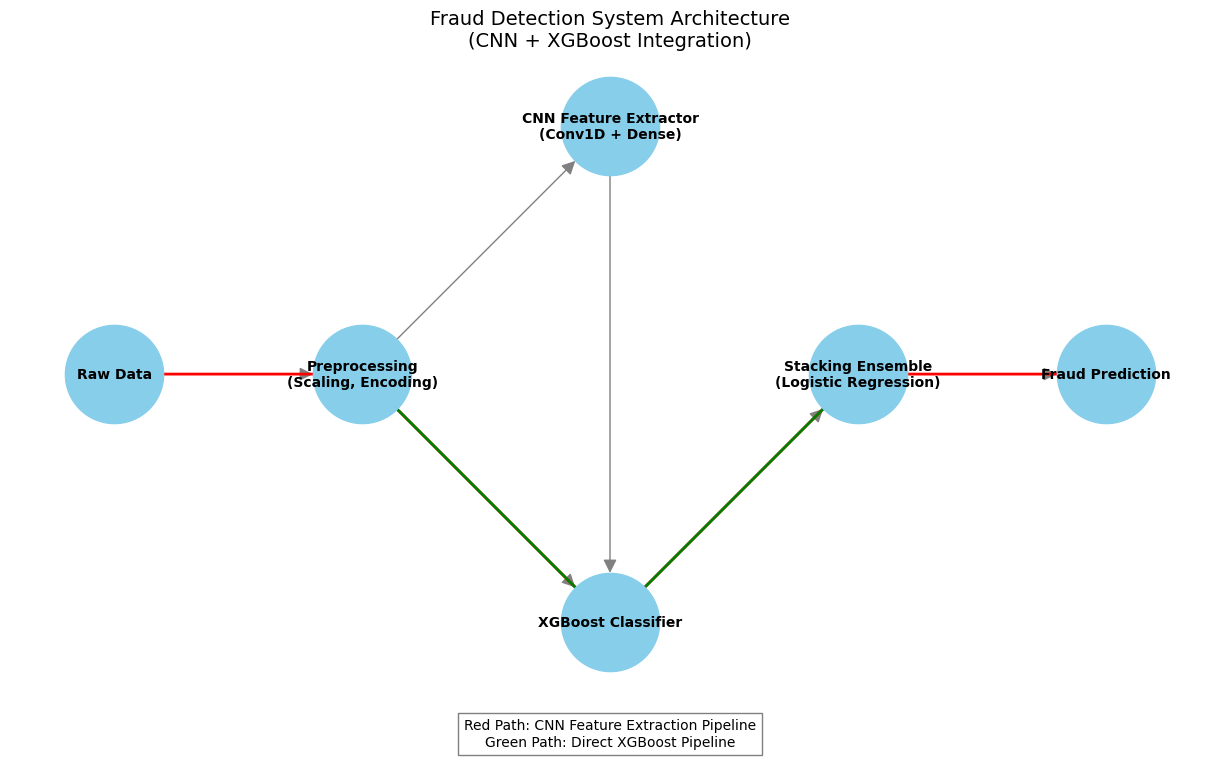

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Define nodes (components)
components = [
    "Raw Data",
    "Preprocessing\n(Scaling, Encoding)",
    "CNN Feature Extractor\n(Conv1D + Dense)",
    "XGBoost Classifier",
    "Stacking Ensemble\n(Logistic Regression)",
    "Fraud Prediction"
]

# Add nodes
for node in components:
    G.add_node(node, shape='box', color='lightblue')

# Define edges (workflow)
edges = [
    ("Raw Data", "Preprocessing\n(Scaling, Encoding)"),
    ("Preprocessing\n(Scaling, Encoding)", "CNN Feature Extractor\n(Conv1D + Dense)"),
    ("CNN Feature Extractor\n(Conv1D + Dense)", "XGBoost Classifier"),
    ("XGBoost Classifier", "Stacking Ensemble\n(Logistic Regression)"),
    ("Preprocessing\n(Scaling, Encoding)", "XGBoost Classifier"),  # Direct XGBoost path
    ("Stacking Ensemble\n(Logistic Regression)", "Fraud Prediction")
]

# Add edges
G.add_edges_from(edges)

# Set positions
pos = {
    "Raw Data": (0, 2),
    "Preprocessing\n(Scaling, Encoding)": (2, 2),
    "CNN Feature Extractor\n(Conv1D + Dense)": (4, 3),
    "XGBoost Classifier": (4, 1),
    "Stacking Ensemble\n(Logistic Regression)": (6, 2),
    "Fraud Prediction": (8, 2)
}

# Draw the diagram
plt.figure(figsize=(12, 6))
nx.draw(
    G, pos,
    with_labels=True,
    node_size=5000,
    node_color="skyblue",
    font_size=10,
    font_weight="bold",
    arrowsize=20,
    edge_color="gray"
)

# Highlight two paths
path1 = nx.shortest_path(G, "Raw Data", "Fraud Prediction")
path2 = ["Preprocessing\n(Scaling, Encoding)", "XGBoost Classifier", "Stacking Ensemble\n(Logistic Regression)"]
nx.draw_networkx_edges(
    G, pos,
    edgelist=list(zip(path1[:-1], path1[1:])),
    edge_color="red",
    width=2,
    arrows=True
)
nx.draw_networkx_edges(
    G, pos,
    edgelist=list(zip(path2[:-1], path2[1:])),
    edge_color="green",
    width=2,
    arrows=True
)

# Add title and legend
plt.title("Fraud Detection System Architecture\n(CNN + XGBoost Integration)", fontsize=14, pad=20)
plt.text(4, 0.5, "Red Path: CNN Feature Extraction Pipeline\nGreen Path: Direct XGBoost Pipeline",
         ha="center", bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files
files.download("plot.png")
